Application of Population Predictive Checks to Nonmentioned Bayesian Models 

## Probabilistic Matrix Factorization using the MovieLens Dataset

In [125]:
%matplotlib inline
import time

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle 

from numpy.linalg import inv
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro import poutine

In [8]:
# Run this when you haven't created a indexed_ratings.csv yet
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/download
ratings_df = pd.read_csv('../data/the-movies-dataset/ratings_small.csv')

# Check the minimum number of ratings a user has posted
print('Minimum number of ratings for each user is ' + str(ratings_df.groupby('userId').size().min()))
print('Minimum number of ratings for each movie is ' + str(ratings_df.groupby('movieId').size().min()))

Minimum number of ratings for each user is 20
Minimum number of ratings for each movie is 1


We will only use movies that have more than 4 ratings, to have more training data available per movie.

In [9]:
# We will only use part of the data that has more than 4 reviews per movie
moviecounts = ratings_df.movieId.value_counts()
ratings_df = ratings_df[ratings_df.movieId.isin(moviecounts.index[moviecounts.gt(4)])].reset_index(drop=True)
print('Minimum number of ratings for each movie is ' + str(ratings_df.groupby('movieId').size().min()))

Minimum number of ratings for each movie is 5


In [ ]:
# Run this when you DON'T have a train_ratings.csv 
# Randomly split the data into train and test
# Specifically, take 5 random ratings out of each user's rating list (therefore, there will be 5 times # of user ratings in the test set)
# For each user id, take out 5 ratings oaut of the dataframe then append them into a new dataframe.
# Then take the difference of the two data frames and the difference will be the train data

def train_test_split_mf(ratings_df):
    for userid in ratings_df.userId.unique() :
        if userid == 1:
            test_ratings = ratings_df[ratings_df['userId']==userid].sample(5, random_state=0)
        else:
            test_ratings = test_ratings.append(ratings_df[ratings_df['userId']==userid].sample(5, random_state=0))
    train_ratings = pd.concat([ratings_df, test_ratings]).drop_duplicates(keep=False).reset_index(drop=True)
    test_ratings = test_ratings.reset_index(drop=True)
    print("Number of ratings in entire dataset is "+ str(len(ratings_df)))
    print("Number of ratings in train dataset is "+  str(len(train_ratings)))
    print("Number of ratings in test dataset is "+ str(len(test_ratings)))
    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split_mf(ratings_df)

In [ ]:
train_ratings.to_csv('../data/train_ratings.csv')
test_ratings.to_csv('../data/test_ratings.csv')

We split randomly the data into train and test data. Specifically, we take 5 random ratings out of each user's rating list, creating 5 x (num of users) ratings in the test set. The remaining data becomes the training set.

In [10]:
# Run this when you have a train_ratings.csv 
train_ratings = pd.read_csv('../data/train_ratings.csv', index_col=0)

Since the IDs of the users and movies have gaps in between, we reindex the IDs so that it will be easier to manipulate the user x movie ratings matrix.

In [ ]:
# Run this when you DON'T have a indexed_train_ratings.csv 
# Reindexing of userId and movieId
unique_userId = train_ratings.userId.unique()
unique_movieId = train_ratings.movieId.unique()

train_ratings['new_user_index'], train_ratings['new_movie_index'] = 0, 0

for old_id, new_id in zip(unique_userId, range(len(unique_userId))):
    train_ratings['new_user_index'].iloc[train_ratings[train_ratings['userId']==old_id].index.tolist()] = new_id

for old_id, new_id in zip(unique_movieId, range(len(unique_movieId))):
    train_ratings['new_movie_index'].iloc[train_ratings[train_ratings['movieId']==old_id].index.tolist()] = new_id

train_ratings.to_csv('../data/indexed_train_ratings.csv')

In [11]:
# Run this when you have a indexed_train_ratings.csv 
train_ratings = pd.read_csv('../data/indexed_train_ratings.csv', index_col=0)

Distribution of All Ratings (with more than 4 reviews)

In [ ]:
# Distribution of All Ratings (with more than 4 reviews)
ratings_df['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Distribution of Train Data Ratings

In [ ]:
# Distribution of Train Data Ratings
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Distribution of Train Data Ratings

In [ ]:
# Distribution of Test Data Ratings
test_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Now we implement the Probabilistic Matrix Factorization (PMF) model, and train the model using the train dataset. In our case, PMF 's objective is to fill in the missing values of the movie matrix $M$, by maximizing the following MAP objective function.

$L = - \Sigma_{(i,j)\in \Omega}\frac{1}{2\sigma^2}(M_{ij}-u_i^Tv_j)^2-\Sigma_{i=1}^{N_u}\frac{\lambda}{2}||u_i||^2-\Sigma_{j=1}^{N_v}\frac{\lambda}{2}||v_j||^2$,

where $u_i$ is the $i$th user vector, $v_j$ the $j$th movie vector, $N_u$ the number of users, $N_v$ the number of movies, $\Omega$ the set of $(i,j)$s that have a rating in the matrix $M$, $\sigma^2$ the variance of $M_{ij} \sim N(u_i^Tv_j, \sigma^2)$. Therefore, each rating in $M$ are assumed to be normally distributed. Also, note that the each user vector $u_i$ and movie vector $v_j$ are initialized from the distribution $N(0, \lambda^{-1}I)$, where $u$ is a $i \times k$ matrix and $v$ is a $j \times k$ matrix.

We have implemented the model below.

#### Imputation of train data using the mean ratings of each user

In [ ]:
# Run this when you DON'T have a mean_imputated_ratings.npy

imputated_ratings = np.empty((ratings_df.userId.nunique(),ratings_df.movieId.nunique()))

for user in range(ratings_df.userId.nunique()):
    imputated_ratings[user] = train_ratings[train_ratings.new_user_index == user]['rating'].mean()
    for column in train_ratings[train_ratings.new_user_index == user]['new_movie_index']:
        imputated_ratings[user, column] = train_ratings[(train_ratings.new_user_index == user)&(train_ratings.new_movie_index == column)]['rating']   

np.save('../data/mean_imputated_ratings.npy', imputated_ratings)

In [6]:
# Run this when you have a imputated_ratings.npy
imputated_ratings = np.load('../data/mean_imputated_ratings.npy')

#### Imputation of train data using zeros

In [ ]:
# Run this when you DON'T have a zero_imputated_ratings.npy

imputated_ratings = np.empty((ratings_df.userId.nunique(),ratings_df.movieId.nunique()))

for user in range(ratings_df.userId.nunique()):
    imputated_ratings[user] = 0
    for column in train_ratings[train_ratings.new_user_index == user]['new_movie_index']:
        imputated_ratings[user, column] = train_ratings[(train_ratings.new_user_index == user)&(train_ratings.new_movie_index == column)]['rating']  

np.save('../data/zero_imputated_ratings.npy', imputated_ratings)

In [12]:
# Run this when you have a zero_imputated_ratings.npy
imputated_ratings = np.load('../data/zero_imputated_ratings.npy')

In [42]:
is_observed = (imputated_ratings != 0)

In [73]:
is_observed[1,2]

False

In [155]:
# Implementation of Poisson Matrix Factorization using Pyro
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        e_u = pyro.sample('e_u', dist.Gamma(1, 1))
        with pyro.plate('user_k', k):
            theta_u_k = pyro.sample('theta_u_k', dist.Gamma(1,e_u))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        n_i = pyro.sample('n_i', dist.Gamma(1, 1))
        with pyro.plate('movie_k', k):
            beta_i_k = pyro.sample('beta_i_k', dist.Gamma(1,n_i))
    with poutine.mask(mask=torch.tensor(is_observed)):
                pyro.sample("obs", dist.Poisson(torch.mm(theta_u_k.T, beta_i_k)), obs=data)

In [156]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) 
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 200/200 [3:02:15, 54.68s/it, step size=3.73e-02, acc. prob=0.795]


In [178]:
with open('../data/poissonmf_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [180]:
rounded_estimate_ratings = calc_average_ratings(posterior_samples['theta_u_k'], posterior_samples['beta_i_k'])

In [181]:
with open('../data/poissonmf_rounded_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(rounded_estimate_ratings, handle, protocol=pickle.HIGHEST_PROTOCOL)

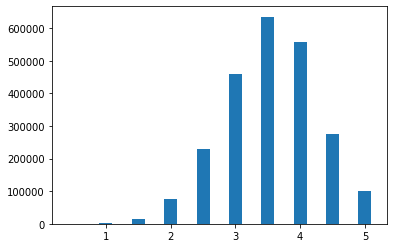

In [182]:
plot_rounded_estimates(rounded_estimate_ratings)